In [1]:
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

import nibabel as nib
from torch.utils.data import Dataset

print_config()

set_determinism(42)

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: c:\Users\<username>\AppData\Local\anaconda3\envs\monai_for_cemra2cta\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 11.1.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow versio

c:\Users\lij6263\AppData\Local\anaconda3\envs\monai_for_cemra2cta\Lib\site-packages\generative\networks\layers\vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
c:\Users\lij6263\AppData\Local\anaconda3\envs\monai_for_cemra2cta\Lib\site-packages\generative\networks\layers\vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


Sagittal slice loader

In [2]:


# Class for getting sagittal slices

class SagittalSliceDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        
        # Get all CTA files
        self.cta_files = sorted([f for f in os.listdir(data_dir) if f.endswith("standardized.nii")])
        
        # Precompute the number of slices for each volume and the cumulative slice counts
        self.slice_counts = []
        self.cum_slices = []
        cum = 0
        for f in self.cta_files:
            path = os.path.join(data_dir, f)
            # Load only header information to determine the shape
            img = nib.load(path)
            num_slices = img.shape[0]  # Assuming the first dimension corresponds to sagittal slices
            self.slice_counts.append(num_slices)
            cum += num_slices
            self.cum_slices.append(cum)
    
    def __len__(self):
        # Total number of slices across all volumes
        return self.cum_slices[-1] if self.cum_slices else 0
    
    def __getitem__(self, idx):
        # Determine which volume this index falls into
        vol_idx = 0
        while idx >= self.cum_slices[vol_idx]:
            vol_idx += 1
        
        # Calculate the local slice index within the selected volume
        if vol_idx == 0:
            slice_idx = idx
        else:
            slice_idx = idx - self.cum_slices[vol_idx - 1]
        
        cta_path = os.path.join(self.data_dir, self.cta_files[vol_idx])
        cemra_path = cta_path.replace("corrected_", "")
        cemra_path = cemra_path.replace("_resampled_cropped_CTI_standardized.nii", "_registered.nii")
        
        cta_img = nib.load(cta_path).get_fdata()
        cemra_img = nib.load(cemra_path).get_fdata()
        
        # Extract the sagittal slice (assuming the first dimension is sagittal)
        cta_slice = cta_img[slice_idx, :, :]
        cemra_slice = cemra_img[slice_idx, :, :]
        
        # Convert slices to torch tensors and add a channel dimension
        cta_slice = torch.tensor(cta_slice, dtype=torch.float32).unsqueeze(0)
        cemra_slice = torch.tensor(cemra_slice, dtype=torch.float32).unsqueeze(0)
        
        if self.transform:
            cta_slice = self.transform(cta_slice)
            cemra_slice = self.transform(cemra_slice)
        
        return cta_slice, cemra_slice

    
    
# Set up training and validation paths

# Paths
train_dir = r"C:\Users\lij6263\Documents\CEMRA_to_CTA_project\no_edge_slices_norm_training"
val_dir = r"C:\Users\lij6263\Documents\CEMRA_to_CTA_project\no_edge_slices_norm_testing"

# Datasets
train_dataset = SagittalSliceDataset(train_dir)
val_dataset = SagittalSliceDataset(val_dir)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

# Check one batch
cta_batch, cemra_batch = next(iter(train_loader))
print("CTA batch shape:", cta_batch.shape)  # Expected: (8, 1, 104, 175)
print("CEMRA batch shape:", cemra_batch.shape)

# Customized Diffusion U-Net that has 1 channel only (black and white, no RGB). 

device = torch.device("cuda")


# model = DiffusionModelUNet(
#     spatial_dims=2,
#     in_channels=1,
#     out_channels=1,
#     num_channels=(128, 256, 256),
#     attention_levels=(False, True, True),
#     num_res_blocks=1,
#     num_head_channels=256,
# )

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=2,  # Now accepts CEMRA + noisy CTA
    out_channels=1,  # Predicts noise
    num_channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
)

model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)


CTA batch shape: torch.Size([8, 1, 104, 175])
CEMRA batch shape: torch.Size([8, 1, 104, 175])


Training loop

In [56]:
n_epochs = 75
val_interval = 5
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler()
total_start = time.time()

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (cta_batch, cemra_batch) in progress_bar:
        # Pad batches to ensure even dimensions
        cemra_batch = F.pad(cemra_batch, (0, 1, 0, 0), mode="constant", value=-1)  # (B, 1, 104, 176)
        cta_batch = F.pad(cta_batch, (0, 1, 0, 0), mode="constant", value=-1)       # (B, 1, 104, 176)
        
        cta_batch, cemra_batch = cta_batch.to(device), cemra_batch.to(device)
        optimizer.zero_grad(set_to_none=True)
        
        with autocast(enabled=True):
            # Sample noise and timesteps
            noise = torch.randn_like(cta_batch)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (cta_batch.shape[0],), device=device).long()
            
            # Add noise to CTA (x0)
            noisy_cta = scheduler.add_noise(cta_batch, noise, timesteps)
            
            # Concatenate CEMRA with noisy CTA
            model_input = torch.cat([cemra_batch, noisy_cta], dim=1)
            
            # Predict noise
            noise_pred = model(model_input, timesteps)
            
            loss = F.mse_loss(noise_pred, noise)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    
    epoch_loss_list.append(epoch_loss / (step + 1))
    
    # Validation and Sampling (similar adjustments needed here)
    # ...

total_time = time.time() - total_start
print(f"Training completed in {total_time} seconds.")

Epoch 0:   2%|▏           | 6/369 [00:57<57:36,  9.52s/it, loss=0.974]


KeyboardInterrupt: 

The evaluation code is located below. This loads the model. 

In [3]:
# Load the saved state dictionary
model = torch.load(r"C:\Users\lij6263\Documents\CEMRA_to_CTA_project\models\no_edge_slices_norm_monai_diffusion_model_3_17_2025.pth", weights_only=False)


Viewing loaded inputs. You can load load images in different order by changing the val_loader parameter above to shuffle = True



(-0.5, 174.5, 103.5, -0.5)

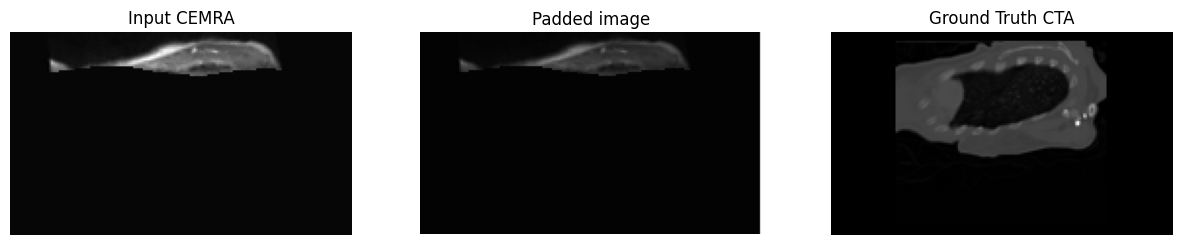

In [19]:
sample_cta, sample_cemra = next(iter(val_loader))
#F.pad(sample_cemra, (0, 1, 0, 0))
input_cemra_np = sample_cemra.cpu().numpy()[0, 0]
filled_img = F.pad(sample_cemra, (0, 1, 0, 0)).cpu().numpy()[0, 0]
ground_truth_cta_np = sample_cta.cpu().numpy()[0, 0]
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(input_cemra_np, cmap="gray")
plt.title("Input CEMRA")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(filled_img, cmap="gray")
plt.title("Padded image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(ground_truth_cta_np, cmap="gray")
plt.title("Ground Truth CTA")
plt.axis("off")

Evaluates model

100%|██████████| 1000/1000 [00:09<00:00, 103.29it/s]


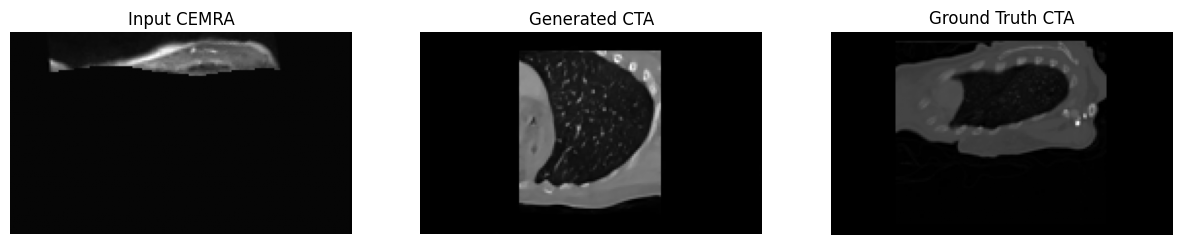

In [6]:
# Example: Generate CTA from a sample CEMRA
model.eval()
with torch.no_grad():
    # Get a CEMRA from validation set
    sample_cta, sample_cemra = next(iter(val_loader))
    sample_cemra = F.pad(sample_cemra, (0, 1, 0, 0), mode="constant", value=-1).to(device)  # (1, 1, 104, 176)
    
    # Initialize noise
    x = torch.randn((1, 1, 104, 176), device=device)
    
    scheduler.set_timesteps(1000)
    
    for t in tqdm(scheduler.timesteps):
        # Concatenate CEMRA with current noisy x
        model_input = torch.cat([sample_cemra, x], dim=1)
        
        # Predict noise
        #noise_pred = model(model_input, t)
        t_tensor = torch.tensor([t], device=device, dtype=torch.long)
        noise_pred = model(model_input, t_tensor)

        
        # Update x using scheduler
        #x = scheduler.step(noise_pred, t, x).prev_sample
        x = scheduler.step(noise_pred, t, x)[0]

    
    generated_cta = x.cpu().numpy()[0, 0]
    input_cemra_np = sample_cemra.cpu().numpy()[0, 0]
    ground_truth_cta_np = sample_cta.cpu().numpy()[0, 0]

# Plot generated CTA


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(input_cemra_np, cmap="gray")
plt.title("Input CEMRA")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(generated_cta, cmap="gray")
plt.title("Generated CTA")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(ground_truth_cta_np, cmap="gray")
plt.title("Ground Truth CTA")
plt.axis("off")

plt.show()


Again. 

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:42<00:00, 23.64it/s]


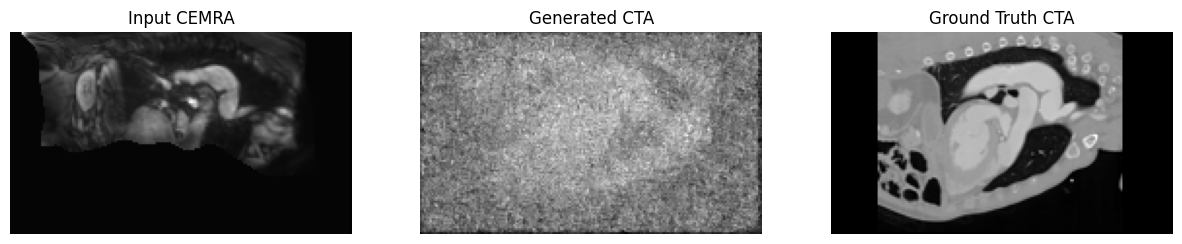

In [20]:
# Example: Generate CTA from a sample CEMRA and display input & ground truth
model.eval()
with torch.no_grad():
    # Get a SINGLE sample from validation set (batch_size=1)
    sample_cta, sample_cemra = next(iter(val_loader))
    # Select the first sample from the batch for both images
    sample_cemra = sample_cemra[0:1]  # shape: (1, 1, 104, 175)
    sample_cta = sample_cta[0:1]      # shape: (1, 1, 104, 175)
    
    # Pad both images to match expected dimensions (104, 176)
    sample_cemra = F.pad(sample_cemra, (0, 1, 0, 0), mode="constant", value=-1).to(device)
    sample_cta = F.pad(sample_cta, (0, 1, 0, 0), mode="constant", value=-1).to(device)
    
    # Initialize noise with matching batch size (1)
    x = torch.randn_like(sample_cemra)  # (1, 1, 104, 176)
    
    scheduler.set_timesteps(1000)
    
    for t in tqdm(scheduler.timesteps):
        # Concatenate CEMRA with current noisy x
        model_input = torch.cat([sample_cemra, x], dim=1)
        
        # Predict noise; convert scalar t into a 1D tensor
        t_tensor = torch.tensor([t], device=device, dtype=torch.long)
        noise_pred = model(model_input, t_tensor)
        
        # Update x using scheduler (unpack the returned tuple)
        x = scheduler.step(noise_pred, t, x)[0]
    
    generated_cta = x.cpu().numpy()[0, 0]
    
    # Convert input CEMRA and ground truth CTA to numpy arrays for display
    input_cemra_np = sample_cemra.cpu().numpy()[0, 0]
    ground_truth_cta_np = sample_cta.cpu().numpy()[0, 0]

# Plot input CEMRA, generated CTA, and ground truth CTA side-by-side
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(input_cemra_np, cmap="gray")
plt.title("Input CEMRA")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(generated_cta, cmap="gray")
plt.title("Generated CTA")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(ground_truth_cta_np, cmap="gray")
plt.title("Ground Truth CTA")
plt.axis("off")

plt.show()


Export Nifti of each slice in the entire testing dataset

In [7]:
import torch
import torch.nn.functional as F
import numpy as np
import nibabel as nib
import os
from tqdm import tqdm

# Ensure output directory exists
output_dir = "output_nifti"
os.makedirs(output_dir, exist_ok=True)

model.eval()
with torch.no_grad():
    for idx, (sample_cta, sample_cemra) in enumerate(tqdm(val_loader)):
        # Select the first sample from the batch
        sample_cemra = sample_cemra.to(device)  # shape: (batch, 1, 104, 175)
        sample_cta = sample_cta.to(device)      # shape: (batch, 1, 104, 175)
        
        # Pad both images to match expected dimensions (104, 176)
        sample_cemra = F.pad(sample_cemra, (0, 1, 0, 0), mode="constant", value=-1)
        sample_cta = F.pad(sample_cta, (0, 1, 0, 0), mode="constant", value=-1)
        
        # Initialize noise with matching batch size
        x = torch.randn_like(sample_cemra)  # shape: (batch, 1, 104, 176)
        
        scheduler.set_timesteps(1000)
        
        for t in scheduler.timesteps:
            # Concatenate CEMRA with current noisy x
            model_input = torch.cat([sample_cemra, x], dim=1)
            
            # Predict noise
            t_tensor = torch.tensor([t], device=device, dtype=torch.long)
            noise_pred = model(model_input, t_tensor)
            
            # Update x using scheduler
            x = scheduler.step(noise_pred, t, x)[0]
        
        generated_cta = x.cpu().numpy()[:, 0]  # shape: (batch, 104, 176)
        input_cemra_np = sample_cemra.cpu().numpy()[:, 0]
        ground_truth_cta_np = sample_cta.cpu().numpy()[:, 0]
        
        # Save as NIfTI files
        def save_nifti(data, filename):
            nifti_img = nib.Nifti1Image(data, affine=np.eye(4))
            nib.save(nifti_img, os.path.join(output_dir, filename))
        
        save_nifti(input_cemra_np, f"input_cemra_{idx}.nii.gz")
        save_nifti(generated_cta, f"generated_cta_{idx}.nii.gz")
        save_nifti(ground_truth_cta_np, f"ground_truth_cta_{idx}.nii.gz")

print(f"NIfTI files saved in {output_dir}")


100%|██████████| 140/140 [23:27<00:00, 10.05s/it]

NIfTI files saved in output_nifti


Customized this one for when test data is from training group to see if overfitting is an issue

100%|██████████| 1000/1000 [00:40<00:00, 24.49it/s]


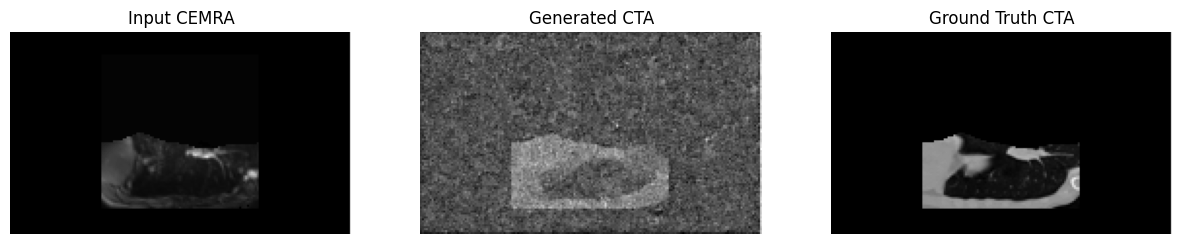

In [16]:
# Example: Generate CTA from a sample CEMRA and display input & ground truth
model.eval()
with torch.no_grad():
    # Get a SINGLE sample from validation set (batch_size=1)
    sample_cta, sample_cemra = next(iter(train_loader))
    # Select the first sample from the batch for both images
    sample_cemra = sample_cemra[0:1]  # shape: (1, 1, 104, 175)
    sample_cta = sample_cta[0:1]      # shape: (1, 1, 104, 175)
    
    # Pad both images to match expected dimensions (104, 176)
    sample_cemra = F.pad(sample_cemra, (0, 1, 0, 0), mode="constant", value=-1).to(device)
    sample_cta = F.pad(sample_cta, (0, 1, 0, 0), mode="constant", value=-1).to(device)
    
    # Initialize noise with matching batch size (1)
    x = torch.randn_like(sample_cemra)  # (1, 1, 104, 176)
    
    scheduler.set_timesteps(1000)
    
    for t in tqdm(scheduler.timesteps):
        # Concatenate CEMRA with current noisy x
        model_input = torch.cat([sample_cemra, x], dim=1)
        
        # Predict noise; convert scalar t into a 1D tensor
        t_tensor = torch.tensor([t], device=device, dtype=torch.long)
        noise_pred = model(model_input, t_tensor)
        
        # Update x using scheduler (unpack the returned tuple)
        x = scheduler.step(noise_pred, t, x)[0]
    
    generated_cta = x.cpu().numpy()[0, 0]
    
    # Convert input CEMRA and ground truth CTA to numpy arrays for display
    input_cemra_np = sample_cemra.cpu().numpy()[0, 0]
    ground_truth_cta_np = sample_cta.cpu().numpy()[0, 0]

# Plot input CEMRA, generated CTA, and ground truth CTA side-by-side
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(input_cemra_np, cmap="gray")
plt.title("Input CEMRA")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(generated_cta, cmap="gray")
plt.title("Generated CTA")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(ground_truth_cta_np, cmap="gray")
plt.title("Ground Truth CTA")
plt.axis("off")

plt.show()


Again

100%|██████████| 1000/1000 [00:41<00:00, 24.35it/s]


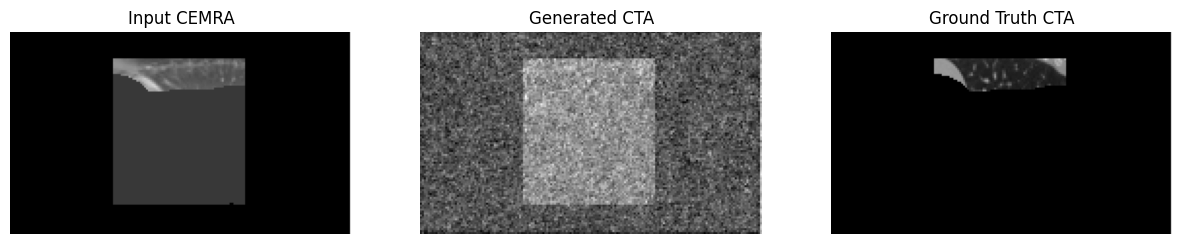

In [17]:
# Example: Generate CTA from a sample CEMRA and display input & ground truth
model.eval()
with torch.no_grad():
    # Get a SINGLE sample from validation set (batch_size=1)
    sample_cta, sample_cemra = next(iter(train_loader))
    # Select the first sample from the batch for both images
    sample_cemra = sample_cemra[0:1]  # shape: (1, 1, 104, 175)
    sample_cta = sample_cta[0:1]      # shape: (1, 1, 104, 175)
    
    # Pad both images to match expected dimensions (104, 176)
    sample_cemra = F.pad(sample_cemra, (0, 1, 0, 0), mode="constant", value=-1).to(device)
    sample_cta = F.pad(sample_cta, (0, 1, 0, 0), mode="constant", value=-1).to(device)
    
    # Initialize noise with matching batch size (1)
    x = torch.randn_like(sample_cemra)  # (1, 1, 104, 176)
    
    scheduler.set_timesteps(1000)
    
    for t in tqdm(scheduler.timesteps):
        # Concatenate CEMRA with current noisy x
        model_input = torch.cat([sample_cemra, x], dim=1)
        
        # Predict noise; convert scalar t into a 1D tensor
        t_tensor = torch.tensor([t], device=device, dtype=torch.long)
        noise_pred = model(model_input, t_tensor)
        
        # Update x using scheduler (unpack the returned tuple)
        x = scheduler.step(noise_pred, t, x)[0]
    
    generated_cta = x.cpu().numpy()[0, 0]
    
    # Convert input CEMRA and ground truth CTA to numpy arrays for display
    input_cemra_np = sample_cemra.cpu().numpy()[0, 0]
    ground_truth_cta_np = sample_cta.cpu().numpy()[0, 0]

# Plot input CEMRA, generated CTA, and ground truth CTA side-by-side
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(input_cemra_np, cmap="gray")
plt.title("Input CEMRA")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(generated_cta, cmap="gray")
plt.title("Generated CTA")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(ground_truth_cta_np, cmap="gray")
plt.title("Ground Truth CTA")
plt.axis("off")

plt.show()
